# Assignment 1
Tiny Imagenet

### Import relative packages

In [1]:
# import some necessary packages
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision.datasets as tv_datasets
import torchvision.transforms as tv_transforms

from datasets import load_dataset
from myDataset import MyDataset

from tqdm import tqdm
import matplotlib.pyplot as plt

### Arguments

In [2]:
# some experimental setup
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

num_epochs = 256
batch_size = 500
num_workers = 12
prefetch_factor = 4
# print_every = 200

optim_name = "AdamW"
optim_kwargs = dict(
    lr=1e-3,
)

# preprocessing pipeline for input images
# transformation = dict()
# for data_type in ("train", "valid"):
#     is_train = data_type=="train"
#     transformation[data_type] = tv_transforms.Compose(([
#         tv_transforms.RandomRotation(degrees=15),
#         tv_transforms.RandomHorizontalFlip(),
#         tv_transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0.1),
#         tv_transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
#     ] if is_train else []) +
#     [
#         tv_transforms.ToTensor(),
#         tv_transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
#     ])
    
print(f"device: {device}")


device: cuda:0


### Load data

In [3]:
# prepare datasets
dataset, loader = {}, {}

# cifar10
# for data_type in ("train", "test"):
#     is_train = data_type=="train"
#     dataset[data_type] = tv_datasets.CIFAR10(
#         root="./data", train=is_train, download=True, transform=transformation[data_type],
#     )
#     loader[data_type] = torch.utils.data.DataLoader(
#         dataset[data_type], batch_size=batch_size, shuffle=is_train, num_workers=num_workers,
#     )

# tiny-imagenet
# def to_tensor(example):
# 	return {
#         "image" : torch.tensor(example["image"].clone().detach().expand(3, -1, -1), dtype=torch.float32),
#         "label" : torch.tensor(example["label"].clone().detach(), dtype=torch.long)
#         }

def to_rgb(example):
	return {
        "image" : example["image"].convert("RGB"),
        "label" : example["label"]
        }

# def train_trans(examples):
#     examples["image"] = [transformation['train'](examples["image"]) for example in examples]
#     return examples

# def valid_trans(examples):
#     examples["image"] = [transformation['valid'](examples["image"]) for example in examples]
#     return examples

for data_type in ("train", "valid"):
    is_train = data_type=="train"
    dataset[data_type] = load_dataset("zh-plus/tiny-imagenet", split=data_type, cache_dir="./data")
    dataset[data_type] = dataset[data_type].map(to_rgb)
    # dataset[data_type] = dataset[data_type].with_format("torch")
    # dataset[data_type] = dataset[data_type].map(to_tensor)
    my_dataset = MyDataset(dataset[data_type], data_type)
    loader[data_type] = torch.utils.data.DataLoader(
        my_dataset, batch_size=batch_size, shuffle=is_train, num_workers=num_workers,
        prefetch_factor=prefetch_factor, pin_memory=True,
    )

print(f"train sample: {len(dataset['train'])}, valid samples: {len(dataset['valid'])}")
print(f"train batches: {len(loader['train'])}, valid batches: {len(loader['valid'])}")

Using the latest cached version of the dataset since zh-plus/tiny-imagenet couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at data/zh-plus___tiny-imagenet/default/0.0.0/5a77092c28e51558c5586e9c5eb71a7e17a5e43f (last modified on Thu Oct 30 00:48:02 2025).
Using the latest cached version of the dataset since zh-plus/tiny-imagenet couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at data/zh-plus___tiny-imagenet/default/0.0.0/5a77092c28e51558c5586e9c5eb71a7e17a5e43f (last modified on Thu Oct 30 00:48:02 2025).


train sample: 100000, valid samples: 10000
train batches: 200, valid batches: 20


### Baseline

In [ ]:
# class BaselineModel(nn.Module):
#     def __init__(self):
#         super(BaselineModel, self).__init__()
#         self.model = nn.Sequential(
#             nn.Conv2d(3, 128, 3, padding=1), nn.ReLU(inplace=True), nn.MaxPool2d(2), nn.Dropout(0.3),
#             nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(inplace=True), nn.MaxPool2d(2), nn.Dropout(0.3),
#             nn.Conv2d(256, 512, 3, padding=1), nn.ReLU(inplace=True),
#             nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(inplace=True),
#             nn.Conv2d(512, 256, 3, padding=1), nn.ReLU(inplace=True), nn.MaxPool2d(2), nn.Dropout(0.3),
#             nn.Flatten(),
#             nn.Linear(256 * 8 * 8, 512), nn.ReLU(inplace=True), nn.Dropout(0.5),
#             nn.Linear(512, 256), nn.ReLU(inplace=True), nn.Dropout(0.5),
#             nn.Linear(256, 128), nn.ReLU(inplace=True), nn.Dropout(0.5),
#             nn.Linear(128, 200),
#         )

#     def forward(self, x):
#         return self.model(x)


### Residual Mechanism

In [ ]:
# class MyResBlock(nn.Module):
#     def __init__(self, in_c, out_c, stride=1):
#         super(MyResBlock, self).__init__()
#         self.conv1 = nn.Conv2d(in_c, out_c, 3, stride=stride, padding=1)
#         self.conv2 = nn.Conv2d(out_c, out_c, 3, padding=1)
#         if in_c != out_c:
#             self.conv3 = nn.Conv2d(in_c, out_c, 1, stride=stride)
#         else:
#             self.conv3 = None
#         self.bn1 = nn.BatchNorm2d(out_c)
#         self.bn2 = nn.BatchNorm2d(out_c)

#     def forward(self, x):
#         y = F.relu(self.bn1(self.conv1(x)))
#         y = F.relu(self.bn2(self.conv2(y)))
#         if self.conv3 is not None:
#             x = self.conv3(x)
#         return F.relu(x + y)

class MyResBlock2(nn.Module):
    def __init__(self, in_c, mid_c, out_c, stride=1):
        super(MyResBlock2, self).__init__()
        self.conv1 = nn.Conv2d(in_c, mid_c, 1)
        self.conv2 = nn.Conv2d(mid_c, mid_c, 3, stride=stride, padding=1)
        self.conv3 = nn.Conv2d(mid_c, out_c, 1)
        if in_c != out_c:
            self.conv4 = nn.Conv2d(in_c, out_c, 1, stride=stride)
        else:
            self.conv4 = None
        self.bn1 = nn.BatchNorm2d(mid_c)
        self.bn2 = nn.BatchNorm2d(mid_c)
        self.bn3 = nn.BatchNorm2d(out_c)

    def forward(self, x):
        y = F.relu(self.bn1(self.conv1(x)))
        y = F.relu(self.bn2(self.conv2(y)))
        y = self.bn3(self.conv3(y))
        if self.conv4 is not None:
            x = self.conv4(x)
        return F.relu(x + y)

class MyResnet(nn.Module):
    def __init__(self, num_block=1):
        super(MyResnet, self).__init__()
        self.before_res = nn.Sequential(
            nn.Conv2d(3, 64, 7, stride=2, padding=3),
            nn.BatchNorm2d(64), nn.ReLU(inplace=True),
        )
        self.res = nn.Sequential(
            MyResBlock2(64, 64, 256, 2), *[MyResBlock2(256, 64, 256) for _ in range((num_block - 1) * 1)],
            MyResBlock2(256, 128, 512, 2), *[MyResBlock2(512, 128, 512) for _ in range((num_block - 1) * 2)],
            MyResBlock2(512, 256, 1024, 2), *[MyResBlock2(1024, 256, 1024) for _ in range((num_block - 1) * 4)],
            # MyResBlock2(1024, 512, 2048, 2), *[MyResBlock2(2048, 512, 2048) for _ in range((num_block - 1) * 2)],
            # MyResBlock2(2048, 1024, 4096, 2), *[MyResBlock2(4096, 1024, 4096) for _ in range((num_block - 1) * 1)],
        )
        self.after_res = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(), nn.Linear(1024, 200),
        )

    def forward(self, x):
        return self.after_res(self.res(self.before_res(x)))


### Attention

In [ ]:
# class MyAttentionBlock(nn.Module):
#     def __init__(self, d_attn, num_heads=4):
#         super(MyAttentionBlock, self).__init__()
#         self.num_heads = num_heads
#         self.mha = nn.MultiheadAttention(embed_dim=d_attn, num_heads=num_heads, batch_first=True)
#         self.ffn = nn.Sequential(
#             nn.Conv2d(d_attn, d_attn*4, 1), nn.ReLU(inplace=True),
#             nn.Conv2d(d_attn*4, d_attn, 1),
#         )
#         self.bn1 = nn.BatchNorm2d(d_attn)
#         self.bn2 = nn.BatchNorm2d(d_attn)

#     def forward(self, x):
#         B, C, W, H = x.shape
#         x_flat = x.flatten(2).permute(0, 2, 1)  # B, L, C
#         attn_out, _ = self.mha(x_flat, x_flat, x_flat)
#         attn_out = attn_out.permute(0, 2, 1).reshape(B, C, W, H)
#         attn_out = F.relu(attn_out + x)
#         attn_out = self.bn1(attn_out)
#         out = self.ffn(attn_out) + attn_out
#         out = self.bn2(out)
#         return out

# class MyAttention(nn.Module):
#     def __init__(self, num_block=1):
#         super(MyAttention, self).__init__()
#         self.before_attn = nn.Sequential(
#             nn.Conv2d(3, 64, 3, padding=1),
#             nn.BatchNorm2d(64), nn.ReLU(inplace=True),
#         )
#         self.attn = nn.Sequential(
#             MyResBlock(64, 128, 2), *[MyAttentionBlock(128) for _ in range(num_block)],
#             MyResBlock(128, 256, 2), *[MyAttentionBlock(256) for _ in range(num_block)],
#             MyResBlock(256, 512, 2), *[MyAttentionBlock(512) for _ in range(num_block)],
#         )
#         self.after_attn = nn.Sequential(
#             nn.AdaptiveAvgPool2d((1,1)),
#             nn.Flatten(), nn.Linear(512, 200)
#         )

#     def forward(self, x):
#         return self.after_attn(self.attn(self.before_attn(x)))


### Model init

In [7]:
# move to device
model = MyResnet(num_block=4)
# model = BaselineModel()
model.to(device)

# print the number of parameters
print(f"number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad) / 1_000_000:.2f}M")

number of parameters: 17.50M


### Start Training

100%|██████████| 200/200 [00:20<00:00,  9.90it/s]

[epoch=  1] loss: 5.3957


100%|██████████| 200/200 [00:18<00:00, 10.59it/s]

[epoch=  2] loss: 5.1239


100%|██████████| 200/200 [00:19<00:00, 10.44it/s]

[epoch=  3] loss: 4.9926


100%|██████████| 200/200 [00:19<00:00, 10.40it/s]

[epoch=  4] loss: 4.8616


100%|██████████| 200/200 [00:19<00:00, 10.41it/s]

[epoch=  5] loss: 4.7411


100%|██████████| 200/200 [00:19<00:00, 10.40it/s]

[epoch=  6] loss: 4.6375


100%|██████████| 200/200 [00:19<00:00, 10.31it/s]

[epoch=  7] loss: 4.5327


100%|██████████| 200/200 [00:19<00:00, 10.39it/s]

[epoch=  8] loss: 4.4429


100%|██████████| 200/200 [00:19<00:00, 10.41it/s]

[epoch=  9] loss: 4.3650


100%|██████████| 200/200 [00:19<00:00, 10.38it/s]

[epoch= 10] loss: 4.2945


100%|██████████| 200/200 [00:19<00:00, 10.42it/s]

[epoch= 11] loss: 4.2848


100%|██████████| 200/200 [00:19<00:00, 10.50it/s]

[epoch= 12] loss: 4.1841


100%|██████████| 200/200 [00:19<00:00, 10.46it/s]

[epoch= 13] loss: 4.1100


100%|██████████| 200/200 [00:19<00:00, 10.35it/s]

[epoch= 14] loss: 4.0572


100%|██████████| 200/200 [00:19<00:00, 10.43it/s]

[epoch= 15] loss: 3.9825


100%|██████████| 200/200 [00:19<00:00, 10.47it/s]

[epoch= 16] loss: 3.9277


100%|██████████| 200/200 [00:19<00:00, 10.40it/s]

[epoch= 17] loss: 3.8667


100%|██████████| 200/200 [00:19<00:00, 10.40it/s]

[epoch= 18] loss: 3.8293


100%|██████████| 200/200 [00:19<00:00, 10.39it/s]

[epoch= 19] loss: 3.7818


100%|██████████| 200/200 [00:19<00:00, 10.38it/s]

[epoch= 20] loss: 3.7383


100%|██████████| 200/200 [00:19<00:00, 10.42it/s]

[epoch= 21] loss: 3.6900


100%|██████████| 200/200 [00:19<00:00, 10.43it/s]

[epoch= 22] loss: 3.6440


100%|██████████| 200/200 [00:19<00:00, 10.41it/s]

[epoch= 23] loss: 3.6016


100%|██████████| 200/200 [00:19<00:00, 10.33it/s]

[epoch= 24] loss: 3.5699


100%|██████████| 200/200 [00:19<00:00, 10.40it/s]

[epoch= 25] loss: 3.5307


100%|██████████| 200/200 [00:19<00:00, 10.44it/s]

[epoch= 26] loss: 3.4998


100%|██████████| 200/200 [00:19<00:00, 10.48it/s]

[epoch= 27] loss: 3.4556


100%|██████████| 200/200 [00:19<00:00, 10.39it/s]

[epoch= 28] loss: 3.4219


100%|██████████| 200/200 [00:19<00:00, 10.41it/s]

[epoch= 29] loss: 3.3952


100%|██████████| 200/200 [00:19<00:00, 10.43it/s]

[epoch= 30] loss: 3.3540


100%|██████████| 200/200 [00:19<00:00, 10.41it/s]

[epoch= 31] loss: 3.3283


100%|██████████| 200/200 [00:19<00:00, 10.37it/s]

[epoch= 32] loss: 3.3046


100%|██████████| 200/200 [00:19<00:00, 10.39it/s]

[epoch= 33] loss: 3.2814


100%|██████████| 200/200 [00:19<00:00, 10.42it/s]

[epoch= 34] loss: 3.2571


100%|██████████| 200/200 [00:19<00:00, 10.39it/s]

[epoch= 35] loss: 3.2299


100%|██████████| 200/200 [00:19<00:00, 10.37it/s]

[epoch= 36] loss: 3.1918


100%|██████████| 200/200 [00:19<00:00, 10.42it/s]

[epoch= 37] loss: 3.1633


100%|██████████| 200/200 [00:19<00:00, 10.37it/s]

[epoch= 38] loss: 3.1382


100%|██████████| 200/200 [00:19<00:00, 10.42it/s]

[epoch= 39] loss: 3.1053


100%|██████████| 200/200 [00:19<00:00, 10.44it/s]

[epoch= 40] loss: 3.0771


100%|██████████| 200/200 [00:19<00:00, 10.42it/s]

[epoch= 41] loss: 3.0610


100%|██████████| 200/200 [00:18<00:00, 10.55it/s]

[epoch= 42] loss: 3.0342


100%|██████████| 200/200 [00:19<00:00, 10.41it/s]

[epoch= 43] loss: 3.0051


100%|██████████| 200/200 [00:19<00:00, 10.43it/s]

[epoch= 44] loss: 2.9910


100%|██████████| 200/200 [00:19<00:00, 10.44it/s]

[epoch= 45] loss: 2.9616


100%|██████████| 200/200 [00:19<00:00, 10.40it/s]

[epoch= 46] loss: 2.9313


100%|██████████| 200/200 [00:19<00:00, 10.34it/s]

[epoch= 47] loss: 2.9247


100%|██████████| 200/200 [00:19<00:00, 10.39it/s]

[epoch= 48] loss: 2.8941


100%|██████████| 200/200 [00:19<00:00, 10.46it/s]

[epoch= 49] loss: 2.8720


100%|██████████| 200/200 [00:19<00:00, 10.45it/s]

[epoch= 50] loss: 2.8509


100%|██████████| 200/200 [00:19<00:00, 10.44it/s]

[epoch= 51] loss: 2.8294


100%|██████████| 200/200 [00:19<00:00, 10.38it/s]

[epoch= 52] loss: 2.8006


100%|██████████| 200/200 [00:19<00:00, 10.43it/s]

[epoch= 53] loss: 2.7844


100%|██████████| 200/200 [00:19<00:00, 10.44it/s]

[epoch= 54] loss: 2.7555


100%|██████████| 200/200 [00:19<00:00, 10.42it/s]

[epoch= 55] loss: 2.7492


100%|██████████| 200/200 [00:19<00:00, 10.32it/s]

[epoch= 56] loss: 2.7303


100%|██████████| 200/200 [00:18<00:00, 10.54it/s]

[epoch= 57] loss: 2.7059


100%|██████████| 200/200 [00:19<00:00, 10.47it/s]

[epoch= 58] loss: 2.6752


100%|██████████| 200/200 [00:19<00:00, 10.43it/s]

[epoch= 59] loss: 2.6650


100%|██████████| 200/200 [00:19<00:00, 10.43it/s]

[epoch= 60] loss: 2.6418


100%|██████████| 200/200 [00:19<00:00, 10.40it/s]

[epoch= 61] loss: 2.6143


100%|██████████| 200/200 [00:19<00:00, 10.34it/s]

[epoch= 62] loss: 2.5993


100%|██████████| 200/200 [00:19<00:00, 10.38it/s]

[epoch= 63] loss: 2.5834


100%|██████████| 200/200 [00:19<00:00, 10.27it/s]

[epoch= 64] loss: 2.5691


100%|██████████| 200/200 [00:19<00:00, 10.45it/s]

[epoch= 65] loss: 2.5439


100%|██████████| 200/200 [00:19<00:00, 10.39it/s]

[epoch= 66] loss: 2.5240


100%|██████████| 200/200 [00:19<00:00, 10.38it/s]

[epoch= 67] loss: 2.5106


100%|██████████| 200/200 [00:19<00:00, 10.36it/s]

[epoch= 68] loss: 2.4828


100%|██████████| 200/200 [00:19<00:00, 10.35it/s]

[epoch= 69] loss: 2.4723


100%|██████████| 200/200 [00:19<00:00, 10.39it/s]

[epoch= 70] loss: 2.4457


100%|██████████| 200/200 [00:19<00:00, 10.51it/s]

[epoch= 71] loss: 2.6043


100%|██████████| 200/200 [00:19<00:00, 10.40it/s]

[epoch= 72] loss: 2.7705


100%|██████████| 200/200 [00:19<00:00, 10.43it/s]

[epoch= 73] loss: 2.5447


100%|██████████| 200/200 [00:19<00:00, 10.39it/s]

[epoch= 74] loss: 2.4669


100%|██████████| 200/200 [00:19<00:00, 10.42it/s]

[epoch= 75] loss: 2.4287


100%|██████████| 200/200 [00:19<00:00, 10.38it/s]

[epoch= 76] loss: 2.3971


100%|██████████| 200/200 [00:19<00:00, 10.42it/s]

[epoch= 77] loss: 2.3696


100%|██████████| 200/200 [00:19<00:00, 10.42it/s]

[epoch= 78] loss: 2.3476


100%|██████████| 200/200 [00:19<00:00, 10.38it/s]

[epoch= 79] loss: 2.3234


100%|██████████| 200/200 [00:19<00:00, 10.36it/s]

[epoch= 80] loss: 2.3027


100%|██████████| 200/200 [00:19<00:00, 10.42it/s]

[epoch= 81] loss: 2.2795


100%|██████████| 200/200 [00:19<00:00, 10.38it/s]

[epoch= 82] loss: 2.2681


100%|██████████| 200/200 [00:19<00:00, 10.42it/s]

[epoch= 83] loss: 2.2352


100%|██████████| 200/200 [00:19<00:00, 10.42it/s]

[epoch= 84] loss: 2.2232


100%|██████████| 200/200 [00:19<00:00, 10.41it/s]

[epoch= 85] loss: 2.2079


100%|██████████| 200/200 [00:19<00:00, 10.42it/s]

[epoch= 86] loss: 2.1798


100%|██████████| 200/200 [00:19<00:00, 10.42it/s]

[epoch= 87] loss: 2.1776


100%|██████████| 200/200 [00:19<00:00, 10.42it/s]

[epoch= 88] loss: 2.1539


100%|██████████| 200/200 [00:19<00:00, 10.37it/s]

[epoch= 89] loss: 2.1328


100%|██████████| 200/200 [00:19<00:00, 10.42it/s]

[epoch= 90] loss: 2.1121


100%|██████████| 200/200 [00:19<00:00, 10.40it/s]

[epoch= 91] loss: 2.1042


100%|██████████| 200/200 [00:19<00:00, 10.43it/s]

[epoch= 92] loss: 2.0977


100%|██████████| 200/200 [00:19<00:00, 10.39it/s]

[epoch= 93] loss: 2.0779


100%|██████████| 200/200 [00:19<00:00, 10.41it/s]

[epoch= 94] loss: 2.0632


100%|██████████| 200/200 [00:19<00:00, 10.40it/s]

[epoch= 95] loss: 2.0366


100%|██████████| 200/200 [00:19<00:00, 10.43it/s]

[epoch= 96] loss: 2.0177


100%|██████████| 200/200 [00:19<00:00, 10.38it/s]

[epoch= 97] loss: 2.0047


100%|██████████| 200/200 [00:19<00:00, 10.42it/s]

[epoch= 98] loss: 2.0005


100%|██████████| 200/200 [00:19<00:00, 10.47it/s]

[epoch= 99] loss: 1.9811


100%|██████████| 200/200 [00:19<00:00, 10.45it/s]

[epoch=100] loss: 1.9710


100%|██████████| 200/200 [00:19<00:00, 10.46it/s]

[epoch=101] loss: 1.9554


100%|██████████| 200/200 [00:19<00:00, 10.43it/s]

[epoch=102] loss: 1.9436


100%|██████████| 200/200 [00:19<00:00, 10.42it/s]

[epoch=103] loss: 1.9153


100%|██████████| 200/200 [00:19<00:00, 10.48it/s]

[epoch=104] loss: 1.9069


100%|██████████| 200/200 [00:19<00:00, 10.45it/s]

[epoch=105] loss: 1.8882


100%|██████████| 200/200 [00:19<00:00, 10.42it/s]

[epoch=106] loss: 1.8728


100%|██████████| 200/200 [00:19<00:00, 10.40it/s]

[epoch=107] loss: 1.8557


100%|██████████| 200/200 [00:19<00:00, 10.41it/s]

[epoch=108] loss: 1.8531


100%|██████████| 200/200 [00:19<00:00, 10.42it/s]

[epoch=109] loss: 1.9847


100%|██████████| 200/200 [00:19<00:00, 10.39it/s]

[epoch=110] loss: 1.9359


100%|██████████| 200/200 [00:19<00:00, 10.42it/s]

[epoch=111] loss: 1.8453


100%|██████████| 200/200 [00:19<00:00, 10.41it/s]

[epoch=112] loss: 1.8301


100%|██████████| 200/200 [00:19<00:00, 10.42it/s]

[epoch=113] loss: 1.7909


100%|██████████| 200/200 [00:19<00:00, 10.30it/s]

[epoch=114] loss: 1.7824


100%|██████████| 200/200 [00:19<00:00, 10.38it/s]

[epoch=115] loss: 1.7558


100%|██████████| 200/200 [00:19<00:00, 10.41it/s]

[epoch=116] loss: 1.7574


100%|██████████| 200/200 [00:19<00:00, 10.43it/s]

[epoch=117] loss: 1.7368


100%|██████████| 200/200 [00:19<00:00, 10.41it/s]

[epoch=118] loss: 1.7242


100%|██████████| 200/200 [00:19<00:00, 10.36it/s]

[epoch=119] loss: 1.7178


100%|██████████| 200/200 [00:19<00:00, 10.41it/s]

[epoch=120] loss: 1.6994


100%|██████████| 200/200 [00:19<00:00, 10.42it/s]

[epoch=121] loss: 1.6911


100%|██████████| 200/200 [00:19<00:00, 10.43it/s]

[epoch=122] loss: 1.6853


100%|██████████| 200/200 [00:19<00:00, 10.37it/s]

[epoch=123] loss: 1.6622


100%|██████████| 200/200 [00:19<00:00, 10.38it/s]

[epoch=124] loss: 1.6577


100%|██████████| 200/200 [00:19<00:00, 10.42it/s]

[epoch=125] loss: 1.6328


100%|██████████| 200/200 [00:19<00:00, 10.43it/s]

[epoch=126] loss: 1.6256


100%|██████████| 200/200 [00:19<00:00, 10.41it/s]

[epoch=127] loss: 1.6190


100%|██████████| 200/200 [00:19<00:00, 10.41it/s]

[epoch=128] loss: 1.6198


100%|██████████| 200/200 [00:19<00:00, 10.41it/s]

[epoch=129] loss: 1.5991


100%|██████████| 200/200 [00:19<00:00, 10.41it/s]

[epoch=130] loss: 1.5754


100%|██████████| 200/200 [00:19<00:00, 10.41it/s]

[epoch=131] loss: 1.5731


100%|██████████| 200/200 [00:19<00:00, 10.36it/s]

[epoch=132] loss: 1.5705


100%|██████████| 200/200 [00:19<00:00, 10.38it/s]

[epoch=133] loss: 1.5492


100%|██████████| 200/200 [00:18<00:00, 10.55it/s]

[epoch=134] loss: 1.5392


100%|██████████| 200/200 [00:19<00:00, 10.46it/s]

[epoch=135] loss: 1.5343


100%|██████████| 200/200 [00:19<00:00, 10.35it/s]

[epoch=136] loss: 1.5245


100%|██████████| 200/200 [00:19<00:00, 10.38it/s]

[epoch=137] loss: 1.5157


100%|██████████| 200/200 [00:19<00:00, 10.42it/s]

[epoch=138] loss: 1.4986


100%|██████████| 200/200 [00:19<00:00, 10.43it/s]

[epoch=139] loss: 1.4963


100%|██████████| 200/200 [00:19<00:00, 10.42it/s]

[epoch=140] loss: 1.4896


100%|██████████| 200/200 [00:19<00:00, 10.36it/s]

[epoch=141] loss: 1.4643


100%|██████████| 200/200 [00:19<00:00, 10.37it/s]

[epoch=142] loss: 1.4586


100%|██████████| 200/200 [00:19<00:00, 10.40it/s]

[epoch=143] loss: 1.4558


100%|██████████| 200/200 [00:18<00:00, 10.53it/s]

[epoch=144] loss: 1.4529


100%|██████████| 200/200 [00:19<00:00, 10.48it/s]

[epoch=145] loss: 1.4317


100%|██████████| 200/200 [00:19<00:00, 10.34it/s]

[epoch=146] loss: 1.4378


100%|██████████| 200/200 [00:19<00:00, 10.41it/s]

[epoch=147] loss: 1.4161


100%|██████████| 200/200 [00:19<00:00, 10.40it/s]

[epoch=148] loss: 1.4051


100%|██████████| 200/200 [00:19<00:00, 10.43it/s]

[epoch=149] loss: 1.4084


100%|██████████| 200/200 [00:19<00:00, 10.44it/s]

[epoch=150] loss: 1.3959


100%|██████████| 200/200 [00:19<00:00, 10.40it/s]

[epoch=151] loss: 1.3798


100%|██████████| 200/200 [00:19<00:00, 10.42it/s]

[epoch=152] loss: 1.3742


100%|██████████| 200/200 [00:19<00:00, 10.28it/s]

[epoch=153] loss: 1.3679


100%|██████████| 200/200 [00:19<00:00, 10.44it/s]

[epoch=154] loss: 1.3555


100%|██████████| 200/200 [00:19<00:00, 10.42it/s]

[epoch=155] loss: 1.3486


100%|██████████| 200/200 [00:19<00:00, 10.48it/s]

[epoch=156] loss: 1.3389


100%|██████████| 200/200 [00:19<00:00, 10.39it/s]

[epoch=157] loss: 1.3332


100%|██████████| 200/200 [00:19<00:00, 10.18it/s]

[epoch=158] loss: 1.3306


100%|██████████| 200/200 [00:19<00:00, 10.43it/s]

[epoch=159] loss: 1.3257


100%|██████████| 200/200 [00:19<00:00, 10.41it/s]

[epoch=160] loss: 1.3170


100%|██████████| 200/200 [00:19<00:00, 10.28it/s]

[epoch=161] loss: 1.3007


100%|██████████| 200/200 [00:19<00:00, 10.36it/s]

[epoch=162] loss: 1.3039


100%|██████████| 200/200 [00:19<00:00, 10.41it/s]

[epoch=163] loss: 1.2859


100%|██████████| 200/200 [00:19<00:00, 10.41it/s]

[epoch=164] loss: 1.2864


100%|██████████| 200/200 [00:19<00:00, 10.40it/s]

[epoch=165] loss: 1.2736


100%|██████████| 200/200 [00:19<00:00, 10.42it/s]

[epoch=166] loss: 1.2751


100%|██████████| 200/200 [00:19<00:00, 10.36it/s]

[epoch=167] loss: 1.2627


100%|██████████| 200/200 [00:19<00:00, 10.43it/s]

[epoch=168] loss: 1.2536


100%|██████████| 200/200 [00:19<00:00, 10.39it/s]

[epoch=169] loss: 1.2473


100%|██████████| 200/200 [00:19<00:00, 10.41it/s]

[epoch=170] loss: 1.2428


100%|██████████| 200/200 [00:19<00:00, 10.37it/s]

[epoch=171] loss: 1.2353


100%|██████████| 200/200 [00:19<00:00, 10.39it/s]

[epoch=172] loss: 1.2230


100%|██████████| 200/200 [00:19<00:00, 10.41it/s]

[epoch=173] loss: 1.2311


100%|██████████| 200/200 [00:19<00:00, 10.39it/s]

[epoch=174] loss: 1.2210


100%|██████████| 200/200 [00:19<00:00, 10.43it/s]

[epoch=175] loss: 1.2158


100%|██████████| 200/200 [00:19<00:00, 10.43it/s]

[epoch=176] loss: 1.2005


100%|██████████| 200/200 [00:19<00:00, 10.41it/s]

[epoch=177] loss: 1.2042


100%|██████████| 200/200 [00:19<00:00, 10.39it/s]

[epoch=178] loss: 1.1981


100%|██████████| 200/200 [00:18<00:00, 10.56it/s]

[epoch=179] loss: 1.1788


100%|██████████| 200/200 [00:19<00:00, 10.48it/s]

[epoch=180] loss: 1.1850


100%|██████████| 200/200 [00:19<00:00, 10.36it/s]

[epoch=181] loss: 1.1759


100%|██████████| 200/200 [00:19<00:00, 10.41it/s]

[epoch=182] loss: 1.1675


100%|██████████| 200/200 [00:19<00:00, 10.40it/s]

[epoch=183] loss: 1.1593


100%|██████████| 200/200 [00:19<00:00, 10.44it/s]

[epoch=184] loss: 1.1563


100%|██████████| 200/200 [00:19<00:00, 10.42it/s]

[epoch=185] loss: 1.1517


100%|██████████| 200/200 [00:19<00:00, 10.37it/s]

[epoch=186] loss: 1.1528


100%|██████████| 200/200 [00:19<00:00, 10.35it/s]

[epoch=187] loss: 1.1427


100%|██████████| 200/200 [00:19<00:00, 10.41it/s]

[epoch=188] loss: 1.1462


100%|██████████| 200/200 [00:19<00:00, 10.48it/s]

[epoch=189] loss: 1.1380


100%|██████████| 200/200 [00:19<00:00, 10.42it/s]

[epoch=190] loss: 1.1399


100%|██████████| 200/200 [00:19<00:00, 10.32it/s]

[epoch=191] loss: 1.1320


100%|██████████| 200/200 [00:19<00:00, 10.37it/s]

[epoch=192] loss: 1.1211


100%|██████████| 200/200 [00:19<00:00, 10.45it/s]

[epoch=193] loss: 1.1136


100%|██████████| 200/200 [00:19<00:00, 10.39it/s]

[epoch=194] loss: 1.1187


100%|██████████| 200/200 [00:19<00:00, 10.39it/s]

[epoch=195] loss: 1.1183


100%|██████████| 200/200 [00:19<00:00, 10.51it/s]

[epoch=196] loss: 1.1065


100%|██████████| 200/200 [00:19<00:00, 10.40it/s]

[epoch=197] loss: 1.0974


100%|██████████| 200/200 [00:19<00:00, 10.39it/s]

[epoch=198] loss: 1.1013


100%|██████████| 200/200 [00:19<00:00, 10.42it/s]

[epoch=199] loss: 1.0921


100%|██████████| 200/200 [00:19<00:00, 10.39it/s]

[epoch=200] loss: 1.0903


100%|██████████| 200/200 [00:19<00:00, 10.33it/s]

[epoch=201] loss: 1.0873


100%|██████████| 200/200 [00:19<00:00, 10.42it/s]

[epoch=202] loss: 1.0853


100%|██████████| 200/200 [00:19<00:00, 10.42it/s]

[epoch=203] loss: 1.0811


100%|██████████| 200/200 [00:19<00:00, 10.38it/s]

[epoch=204] loss: 1.0728


100%|██████████| 200/200 [00:19<00:00, 10.34it/s]

[epoch=205] loss: 1.0727


100%|██████████| 200/200 [00:19<00:00, 10.37it/s]

[epoch=206] loss: 1.0648


100%|██████████| 200/200 [00:19<00:00, 10.39it/s]

[epoch=207] loss: 1.0716


100%|██████████| 200/200 [00:19<00:00, 10.36it/s]

[epoch=208] loss: 1.0572


100%|██████████| 200/200 [00:19<00:00, 10.36it/s]

[epoch=209] loss: 1.0570


100%|██████████| 200/200 [00:19<00:00, 10.40it/s]

[epoch=210] loss: 1.0594


100%|██████████| 200/200 [00:19<00:00, 10.42it/s]

[epoch=211] loss: 1.0494


100%|██████████| 200/200 [00:19<00:00, 10.40it/s]

[epoch=212] loss: 1.0452


100%|██████████| 200/200 [00:19<00:00, 10.36it/s]

[epoch=213] loss: 1.0486


100%|██████████| 200/200 [00:19<00:00, 10.28it/s]

[epoch=214] loss: 1.0444


100%|██████████| 200/200 [00:19<00:00, 10.27it/s]

[epoch=215] loss: 1.0445


100%|██████████| 200/200 [00:19<00:00, 10.36it/s]

[epoch=216] loss: 1.0467


100%|██████████| 200/200 [00:19<00:00, 10.40it/s]

[epoch=217] loss: 1.0366


100%|██████████| 200/200 [00:18<00:00, 10.58it/s]

[epoch=218] loss: 1.0438


100%|██████████| 200/200 [00:19<00:00, 10.41it/s]

[epoch=219] loss: 1.0308


100%|██████████| 200/200 [00:19<00:00, 10.39it/s]

[epoch=220] loss: 1.0314


100%|██████████| 200/200 [00:19<00:00, 10.41it/s]

[epoch=221] loss: 1.0374


100%|██████████| 200/200 [00:19<00:00, 10.40it/s]

[epoch=222] loss: 1.0278


100%|██████████| 200/200 [00:19<00:00, 10.33it/s]

[epoch=223] loss: 1.0202


100%|██████████| 200/200 [00:19<00:00, 10.40it/s]

[epoch=224] loss: 1.0205


100%|██████████| 200/200 [00:19<00:00, 10.39it/s]

[epoch=225] loss: 1.0180


100%|██████████| 200/200 [00:19<00:00, 10.40it/s]

[epoch=226] loss: 1.0100


100%|██████████| 200/200 [00:19<00:00, 10.40it/s]

[epoch=227] loss: 1.0124


100%|██████████| 200/200 [00:19<00:00, 10.31it/s]

[epoch=228] loss: 1.0160


100%|██████████| 200/200 [00:19<00:00, 10.35it/s]

[epoch=229] loss: 1.0101


100%|██████████| 200/200 [00:19<00:00, 10.42it/s]

[epoch=230] loss: 1.0065


100%|██████████| 200/200 [00:19<00:00, 10.39it/s]

[epoch=231] loss: 1.0036


100%|██████████| 200/200 [00:19<00:00, 10.35it/s]

[epoch=232] loss: 1.0164


100%|██████████| 200/200 [00:19<00:00, 10.49it/s]

[epoch=233] loss: 1.0152


100%|██████████| 200/200 [00:19<00:00, 10.45it/s]

[epoch=234] loss: 1.0033


100%|██████████| 200/200 [00:19<00:00, 10.40it/s]

[epoch=235] loss: 1.0052


100%|██████████| 200/200 [00:19<00:00, 10.31it/s]

[epoch=236] loss: 0.9983


100%|██████████| 200/200 [00:19<00:00, 10.40it/s]

[epoch=237] loss: 1.0048


100%|██████████| 200/200 [00:19<00:00, 10.42it/s]

[epoch=238] loss: 1.0018


100%|██████████| 200/200 [00:19<00:00, 10.39it/s]

[epoch=239] loss: 0.9935


100%|██████████| 200/200 [00:19<00:00, 10.38it/s]

[epoch=240] loss: 1.0053


100%|██████████| 200/200 [00:19<00:00, 10.34it/s]

[epoch=241] loss: 0.9980


100%|██████████| 200/200 [00:19<00:00, 10.42it/s]

[epoch=242] loss: 1.0022


100%|██████████| 200/200 [00:19<00:00, 10.41it/s]

[epoch=243] loss: 0.9993


100%|██████████| 200/200 [00:19<00:00, 10.39it/s]

[epoch=244] loss: 1.0052


100%|██████████| 200/200 [00:19<00:00, 10.36it/s]

[epoch=245] loss: 1.0006


100%|██████████| 200/200 [00:19<00:00, 10.38it/s]

[epoch=246] loss: 1.0010


100%|██████████| 200/200 [00:19<00:00, 10.34it/s]

[epoch=247] loss: 1.0024


100%|██████████| 200/200 [00:19<00:00, 10.49it/s]

[epoch=248] loss: 1.0017


100%|██████████| 200/200 [00:19<00:00, 10.40it/s]

[epoch=249] loss: 0.9972


100%|██████████| 200/200 [00:19<00:00, 10.42it/s]

[epoch=250] loss: 0.9876


100%|██████████| 200/200 [00:19<00:00, 10.43it/s]

[epoch=251] loss: 0.9963


100%|██████████| 200/200 [00:19<00:00, 10.08it/s]

[epoch=252] loss: 0.9960


100%|██████████| 200/200 [00:19<00:00, 10.38it/s]

[epoch=253] loss: 1.0030


100%|██████████| 200/200 [00:19<00:00, 10.33it/s]

[epoch=254] loss: 0.9963


100%|██████████| 200/200 [00:19<00:00, 10.40it/s]

[epoch=255] loss: 0.9905


100%|██████████| 200/200 [00:19<00:00, 10.45it/s]


[epoch=256] loss: 0.9946Finished Training


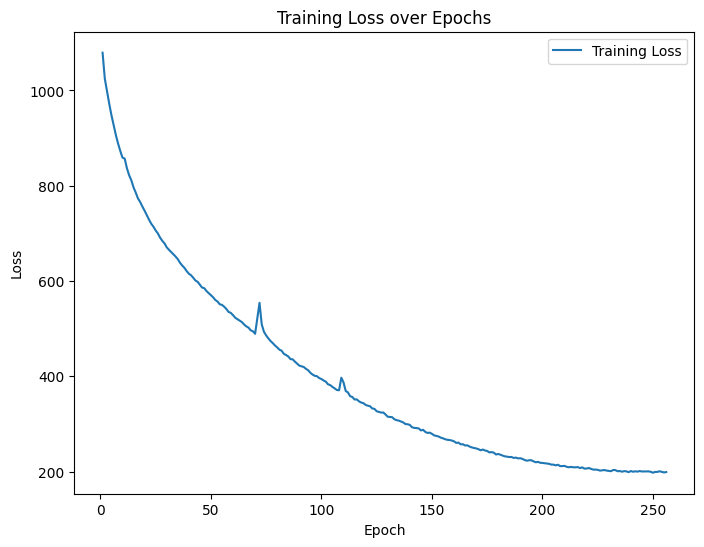

In [8]:
# the network optimizer
optimizer = getattr(optim, optim_name)(model.parameters(), **optim_kwargs)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

# loss function
criterion = nn.CrossEntropyLoss()

# training loop
model.train()
loss_record = []
for epoch in range(num_epochs):

    running_loss = 0.0
    for i, batch in tqdm(enumerate(loader["train"]), total=len(loader["train"])):
        img, target = batch['image'].to(device), batch['label'].to(device)

        pred = model(img)
        loss = criterion(pred, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        # if i % print_every == print_every - 1:
        #     print(f"[epoch={epoch + 1:3d}, iter={i + 1:5d}] loss: {running_loss / print_every:.3f}")
        #     running_loss = 0.0
    print(f"[epoch={epoch + 1:3d}] loss: {running_loss / len(loader['train']):.4f}", end='')
    loss_record.append(running_loss)
    scheduler.step()
    # break

print("Finished Training")

plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), loss_record, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()


### Evaluating its accuracy

In [10]:
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for batch in tqdm(loader["train"], total=len(loader["train"])):
        img, target = batch['image'].to(device), batch['label'].to(device)

        # make prediction
        pred = model(img)

        # accumulate
        total += len(target)
        correct += (torch.argmax(pred, dim=1) == target).sum().item()
print(f"Accuracy of the network on the {total} train images: {100 * correct / total:.2f}%")

correct, total = 0, 0
with torch.no_grad():
    for batch in tqdm(loader["valid"], total=len(loader["valid"])):
        img, target = batch['image'].to(device), batch['label'].to(device)

        # make prediction
        pred = model(img)

        # accumulate
        total += len(target)
        correct += (torch.argmax(pred, dim=1) == target).sum().item()
print(f"Accuracy of the network on the {total} valid images: {100 * correct / total:.2f}%")

100%|██████████| 200/200 [00:14<00:00, 13.92it/s]


Accuracy of the network on the 100000 train images: 76.49%


100%|██████████| 20/20 [00:01<00:00, 15.17it/s]

Accuracy of the network on the 10000 valid images: 46.40%
